![IFMG](https://storage.googleapis.com/ifmg/IFMG.png)

---
# Metaheurísticas - Ant Colony Optimization

### Professor: Felipe A. L. Reis

---
### Instruções Iniciais

#### Problemas

Para aprendizado do Algoritmo *Ant Colony Optimizaton* , iremos estudar o seguinte problema:

* Problema do Caixeiro Viajante (TSP)

#### Bibliotecas Python

* ACopy - Ant Colony Optimization for the Traveling Salesman Problem

A biblioteca [ACopy](https://pypi.org/project/acopy/) é utilizada para implementação do algoritmo ACO (*Ant Colony Optimization*) para solução do Problema do Caixeiro Viajante. Sua documentação pode ser encontrada no link abaixo:
* https://acopy.readthedocs.io/en/latest/usage.html#quickstart

#### Datasets

No Problema 2, iremos utilizar o seguinte repositório MP-TESTDATA - The TSPLIB Symmetric Traveling Salesman Problem Instances, contendo arquivos para uso em problemas de Caixeiro Viajante. O acesso aos problemas pode ser feito pelo link:
* http://elib.zib.de/pub/mp-testdata/tsp/tsplib/tsp/

Dentre os arquivos contendo os repositórios, utilizaremos o arquivo "29 Cities in Bavaria (geographical distance)", que pode ser acessado diretamente pelo link: 
* http://elib.zib.de/pub/mp-testdata/tsp/tsplib/tsp/bayg29.tsp

#### Referências

O tutorial abaixo foi inspirado nas seguintes links:
* https://acopy.readthedocs.io/en/latest/usage.html#quickstart
* https://github.com/Akavall/AntColonyOptimization
* https://github.com/pjmattingly/ant-colony-optimization/
* https://github.com/dilsonpereira/Formigueiro

---
### Instalação de bibliotecas 

In [7]:
'''
#instalação biblioteca acopy (otimização por colônia de formigas)
!pip install acopy

#instalação biblioteca tsplib95 (leitura de grafos)
!pip install tsplib95

#instalação biblioteca pygad
!pip install pygad
'''

'\n#instalação biblioteca acopy (otimização por colônia de formigas)\n!pip install acopy\n\n#instalação biblioteca tsplib95 (leitura de grafos)\n!pip install tsplib95\n\n#instalação biblioteca pygad\n!pip install pygad\n'

### Importação de bibliotecas 

In [8]:
import scipy.optimize as opt
import numpy as np
import numpy.random as rd
import plot as plot
import operator

import matplotlib.pyplot as plt
import matplotlib        as mpl

%matplotlib inline

import acopy
import pygad
import tsplib95

### Classe Trilha

A classe abaixo será utilizada para implementação do caixeiro viajante com o ACO.

A classe contém 2 atributos: caminho e custo. A soma dos valores do caminho deverá ser igual à custo.

In [9]:
class Trilha:
    def __init__(self, caminho, custo):
        self.caminho = caminho
        self.custo = custo
    
    #função utilizada para ordenação
    def __lt__(self, other):
         return self.custo < other.custo

---
### Problema 1: Problema do Caixeiro Viajante

O problema do Caixeiro Viajante (*Traveling Salesman Problem* - TSP) pode ser resolvido utilizando Otimização por Colônia de Formigas.

Nesta seção, iremos utilizar o ACO para solucionar o problema do caixeiro viajante, para um conjunto limitado de cidades / localidades.

Serão adotados os seguintes procedimentos:
- Serão definidos um conjunto de nós utilizando a posição geográfica *(x, y)*. 
- As distâncias entre duas cidades serão cálculadas com base na distância euclidiana entre os nós.
- A cidade de início (e fim) será gerada por sorteio (primeira cidade sorteada).

#### Métodos para gerar Coordenadas Geográficas e calcular a Distância Euclidiana

In [10]:
def f_generate_coords(num_nodes, interv=10, randint=False):
    if(not randint):
        return [[rd.uniform(-interv, interv), rd.uniform(-interv, interv)] for i in range(num_nodes)]
    else:
        return [[rd.randint(-interv, interv), rd.randint(-interv, interv)] for i in range(num_nodes)]

def f_calc_dist_euclidiana(x1, x2, y1, y2):
    return (((x1 - x2)**2) + ((y1 - y2)**2))**0.5

def f_calc_dist_eucl(coords):
    len_coords = len(coords)
    distances = np.full((len_coords, len_coords), np.inf)
    
    for i in range(len_coords):
        for j in range(i+1, len_coords):
            x1, x2, y1, y2 = coords[i][0], coords[j][0], coords[i][1], coords[j][1]
            d = f_calc_dist_euclidiana(x1, x2, y1, y2)
            distances[i][j] = d
            distances[j][i] = d
        
    return distances

#### Busca Gulosa

Os métodos abaixo implementam a busca gulosa, para definir a solução inicial.

A função `f_solucao_gulosa` foi atualizada em relação à versão disponibilizada junto à aula Simulated Annealing.

A nova versão reduz o número de operações e permite iniciar a busca por qualquer posição da matriz.

In [11]:
def f_obter_menor_valor(vetor, nodes):
    minimo, index = np.inf, 0
        
    for i in nodes:
        if(vetor[i] < minimo):
            minimo = vetor[i]
            index = i
            
    return minimo, index

def f_solucao_gulosa(distances, indice, return_vet_custos=False):
    path, custo, nodes = [], [], []
    curr = indice
    
    #gera sequencia de nós
    nodes.append(indice)
    nodes.extend([i for i in range(0, indice)])
    nodes.extend([i for i in range(indice+1, len(distances))])
        
    #caminha pela matriz, de forma gulosa
    for i in range(0, len(distances)-1):
        minimo, j = f_obter_menor_valor(distances[curr][:], nodes)
        
        custo.append(minimo)
        path.append(curr)
        nodes.remove(curr)
        curr = j
    
    #volta ao nó original
    minimo, j = f_obter_menor_valor(distances[curr][:], [indice])
    custo.append(minimo)
    path.append(curr)
                
    if(return_vet_custos):
        return path, custo
    
    return path, sum(custo)

#### Busca Aleatória

Os métodos abaixo implementam a busca aleatória, para definir a solução inicial.

A função `f_solucao_aleatoria_prob` foi desenvolvida para definir uma solução aleatória com base em uma matriz de probabilidades.

In [12]:
def f_obter_random_sol(vetor, nodes, prob):
    index = rd.choice(nodes, 1, p=prob)[0]
    minimo = vetor[index]

    return minimo, index

def f_gera_probabilidades(probab, nodes, curr):
    p = []
    for n in nodes:
        p.append(probab[curr][n])
    
    #redefine as probabilidades para que somem 1.
    p /= sum(p) 
    
    return p

def f_solucao_aleatoria_prob(distances, indice, probab, return_vet_custos=False):
    path, custo, nodes = [], [], []
    curr = indice
    
    #gera sequencia de nós
    #nodes.append(indice)
    nodes.extend([i for i in range(0, indice)])
    nodes.extend([i for i in range(indice+1, len(distances))])
        
    #caminha pela matriz
    for i in range(0, len(distances)-1):
        p = f_gera_probabilidades(probab, nodes, curr)
        minimo, j = f_obter_random_sol(distances[curr][:], nodes, p)
        
        custo.append(minimo)
        path.append(curr)
        nodes.remove(j)
        curr = j
    
    #volta ao nó original
    minimo, j = f_obter_random_sol(distances[curr][:], [indice], [1])
    custo.append(minimo)
    path.append(curr)
                
    if(return_vet_custos):
        return path, custo
    
    return path, sum(custo)

#### Métodos para gerar candidato e calcular o custo da nova solução

In [13]:
def f_gera_candidato(sol_atual):
    candidate = sol_atual.copy()
    
    #gera números aleatorios
    i, j = np.random.randint(1, len(sol_atual)-1, 2)
    
    #corrige sorteios de índices iguais
    if(i == j): 
        j = j+1 if j == 1 else j-1
        
    #troca os valores
    x = candidate[j]
    candidate[j] = candidate[i]
    candidate[i] = x
    
    return candidate

def f_calcula_custo(distances, candidate):
    custo = 0
    curr = candidate[0]
          
    for j in candidate[1:]:
        custo += distances[curr][j]
        curr = j
        
    custo += distances[curr][candidate[0]]

    return custo

#### Estudo inicial do problema

[[-2, -3], [-9, 8], [-2, 1], [3, -2], [4, -11]]


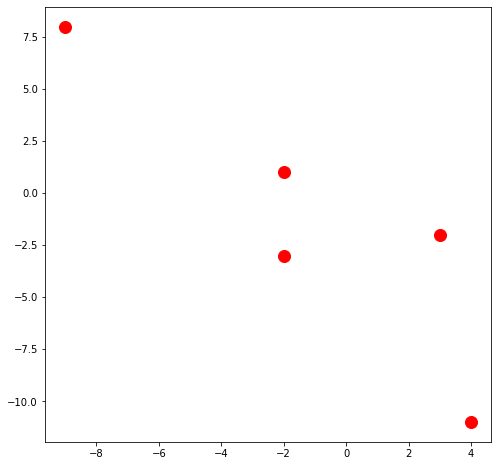

[[  inf 13.04  4.    5.1  10.  ]
 [13.04   inf  9.9  15.62 23.02]
 [ 4.    9.9    inf  5.83 13.42]
 [ 5.1  15.62  5.83   inf  9.06]
 [10.   23.02 13.42  9.06   inf]]


In [14]:
np.random.seed(6)

#gera as coordenadas cartesianas
coords = f_generate_coords(5, interv=12, randint=True)
print(coords)

#plota as cidades (via coordenadas cartesianas)
plot.plot_cities(list(map(lambda a: a[0], coords)), list(map(lambda a: a[1], coords)))

#imprime matriz de distâncias
distances = f_calc_dist_eucl(coords)
np.set_printoptions(precision=2)
print(distances)

In [15]:
#gera resultado inicial (por busca gulosa) e imprime o custo

print(distances, '\n')
path, custo = f_solucao_gulosa(distances, 0, return_vet_custos=True)

print('caminho =', path)
print(custo, '=', sum(custo))

[[  inf 13.04  4.    5.1  10.  ]
 [13.04   inf  9.9  15.62 23.02]
 [ 4.    9.9    inf  5.83 13.42]
 [ 5.1  15.62  5.83   inf  9.06]
 [10.   23.02 13.42  9.06   inf]] 

caminho = [0, 2, 3, 4, 1]
[4.0, 5.830951894845301, 9.055385138137417, 23.021728866442675, 13.038404810405298] = 54.94647070983069


In [16]:
#imprime a matriz de distâncias
print('distâncias:')
print(distances, '\n')

#atualiza a matriz de feromônios, distribuindo uniformente valores nas trilhas
print('feromônios:')
feromonios = np.full_like(distances, (1 / distances))
print(feromonios, '\n')

distâncias:
[[  inf 13.04  4.    5.1  10.  ]
 [13.04   inf  9.9  15.62 23.02]
 [ 4.    9.9    inf  5.83 13.42]
 [ 5.1  15.62  5.83   inf  9.06]
 [10.   23.02 13.42  9.06   inf]] 

feromônios:
[[0.   0.08 0.25 0.2  0.1 ]
 [0.08 0.   0.1  0.06 0.04]
 [0.25 0.1  0.   0.17 0.07]
 [0.2  0.06 0.17 0.   0.11]
 [0.1  0.04 0.07 0.11 0.  ]] 



In [17]:
#gera resultado inicial (por busca aleatória) e imprime o custo
path, custo = f_solucao_aleatoria_prob(distances, 0, feromonios, return_vet_custos=True)

print('caminho =', path)
print(custo, '=', sum(custo))

caminho = [0, 3, 2, 1, 4]
[5.0990195135927845, 5.830951894845301, 9.899494936611665, 23.021728866442675, 10.0] = 53.851195211492424


#### Implementação do ACO (Mínimo)

O código abaixo implementa o algoritmo Ant Colony Optimization (ACO) em uma versão simples.

In [18]:
def gera_trilhas(distances, qtd_formigas, feromonios):
    trilhas = []
    ini_trilha = [rd.randint(len(distances)) for i in range(0, qtd_formigas)] #posição inicial da trilha
    
    #gera soluções
    for t in ini_trilha:
        sol = f_solucao_aleatoria_prob(distances, t, feromonios)
        trilha = Trilha(sol[0], sol[1])
        trilhas.append(trilha)
    
    #ordena trilhas
    sort_trilhas = sorted(trilhas, key=operator.attrgetter('custo'))
       
    return sort_trilhas

def atualiza_feromonios(feromonios, trilha, incremento):
    curr = trilha.caminho[0]
    
    #atualiza trilha de feromonios, baseado no melhr
    for j in trilha.caminho[1:]:
        feromonios[curr][j] += incremento
        curr = j
        
    feromonios[curr][trilha.caminho[0]] += incremento

    return feromonios

def evapora_feromonios(feromonios, rho):
    feromonios -= rho
    
    #zera os feromônios caso se o valor for menor q zero
    #feromonios[feromonios[:] <= 0] = 10**(-8)
    
    return feromonios

In [19]:
def basic_aco(distances, qtd_formigas, max_iteracoes):    
    #variáveis iniciais
    trilhas = []
    best_trilha = Trilha([], np.inf)
    
    #define condições iniciais
    feromonios = np.full_like(distances, (1 / distances))
    incremento = max(0.2, 1/len(feromonios)) #define taxa de adição de feromônios
    
    # executa o ACO
    for i in range(max_iteracoes):        
        #inicia os valores
        trilhas = gera_trilhas(distances, qtd_formigas, feromonios)
    
        #percorre as trilhas deixadas pelas formigas
        if(trilhas[0].custo < best_trilha.custo):
            best_trilha = trilhas[0]
            print(best_trilha.custo)
        
        #atualiza feromonios 
        feromonios = atualiza_feromonios(feromonios, best_trilha, incremento)
        
    return best_trilha

In [20]:
np.random.seed(6)

#define as coordenadas iniciais
coords = f_generate_coords(5, interv=12, randint=True)
distances = f_calc_dist_eucl(coords)

# execução do ACO
simul = basic_aco(distances=distances, qtd_formigas=5, max_iteracoes=10)
print(simul.caminho, simul.custo)

48.57537942656239
47.82423677999968
[3, 2, 1, 0, 4] 47.82423677999968


In [21]:
np.random.seed(6)

#define as coordenadas iniciais
coords = f_generate_coords(100, interv=1000, randint=False)
distances = f_calc_dist_eucl(coords)

# execução do ACO
simul = basic_aco(distances=distances, qtd_formigas=80, max_iteracoes=100)
print(simul.caminho, simul.custo)

63386.12604857584
62890.53437445327
60171.165737780044
60105.654074846
58392.6573146185
57513.845730893
55791.00776494309
54441.08564168057
54295.23384236601
52001.944291477754
51532.541927449936
50710.224141602164
50462.54207434944
50462.495777300726
50424.39614721544
48356.48733957118
46927.871560623185
44406.77727574814
43780.66765590923
43746.4772697475
43677.93052666796
[33, 82, 94, 96, 60, 92, 23, 32, 99, 7, 43, 73, 15, 78, 29, 56, 76, 91, 64, 66, 40, 85, 62, 4, 3, 53, 88, 45, 2, 51, 63, 10, 98, 59, 89, 42, 49, 22, 28, 13, 24, 72, 5, 35, 58, 95, 16, 8, 0, 71, 31, 86, 41, 1, 25, 37, 18, 50, 81, 54, 6, 55, 57, 48, 74, 84, 67, 12, 44, 20, 11, 90, 30, 21, 38, 39, 52, 26, 68, 46, 80, 77, 14, 61, 75, 36, 79, 93, 19, 65, 87, 97, 83, 69, 9, 34, 17, 70, 47, 27] 43677.93052666796


#### Implementação do ACO

O código abaixo implementa o algoritmo Ant Colony Optimization (ACO) com algumas melhorias em relação à versão anterior.

No entanto, nem todas as modificações possíveis foram implementadas nesta versão do código.

In [23]:
def atualiza_feromonios(feromonios, trilha, alfa):
    curr = trilha.caminho[0]
    
    #atualiza trilha de feromonios, baseado no melhr
    for j in trilha.caminho[1:]:
        feromonios[curr][j] *= alfa
        curr = j
        
    feromonios[curr][trilha.caminho[0]] *= alfa

    return feromonios

def aco(distances, qtd_formigas, max_iteracoes, rho=0.03, alfa= 1, beta=3):
    #rho - taxa evaporação dos feromônios; 
    #beta - importância relativa das distâncias
    #alpha - importância relativa dos feromônios
    
    #variáveis iniciais
    trilhas = []
    best_trilha = Trilha([], np.inf)
    
    #define condições iniciais
    feromonios = np.full_like(distances, ((1 / distances)**beta))
    
    # executa o ACO
    for i in range(max_iteracoes):        
        #inicia os valores
        trilhas = gera_trilhas(distances, qtd_formigas, feromonios)
    
        #percorre as trilhas deixadas pelas formigas
        if(trilhas[0].custo < best_trilha.custo):
            best_trilha = trilhas[0]
            print(best_trilha.custo)
        
        #atualiza feromonios 
        feromonios = atualiza_feromonios(feromonios, best_trilha, alfa)
        
        #evapora feromônios
        feromonios = evapora_feromonios(feromonios, rho)
        
    return best_trilha

In [25]:
np.random.seed(6)

#define as coordenadas iniciais
coords = f_generate_coords(100, interv=1000, randint=False)
distances = f_calc_dist_eucl(coords)

# execução do ACO
simul = aco(distances=distances, qtd_formigas=80, max_iteracoes=100, rho=0.00003, alfa=2, beta=5)
print(simul.caminho, simul.custo)

20559.318573980898
20559.318573980887
20559.318573980883
[61, 63, 98, 75, 59, 2, 51, 10, 87, 68, 46, 26, 19, 28, 22, 89, 6, 70, 44, 55, 17, 99, 20, 11, 34, 48, 29, 84, 74, 56, 9, 90, 30, 78, 15, 7, 73, 43, 21, 52, 16, 4, 65, 14, 77, 80, 76, 40, 91, 82, 85, 66, 64, 36, 79, 47, 93, 94, 96, 60, 54, 23, 50, 25, 92, 86, 31, 1, 41, 81, 0, 18, 71, 37, 8, 67, 12, 57, 32, 3, 42, 62, 49, 5, 24, 33, 27, 95, 53, 88, 69, 83, 97, 72, 13, 58, 45, 35, 38, 39] 20559.318573980883


---
### Problema 2: Problema do Caixeiro Viajante

O problema do Caixeiro viajante pode ser resolvido utilizando Otimização por Colônia de Formigas.

In [18]:
#lê o arquivo com os dados
with open('bayg29.txt') as f:
    content = f.read().splitlines()

#gera matriz inicial
len_ct = len(content)+1
dist = np.full((len_ct, len_ct), np.inf)

#preenche matriz (não simétrica)
for i in range(0, len_ct-1):
    dist[i][i+1:] = content[i].split(',')

#transforma a matriz inicial em matriz simétrica
for i in range(0, len(dist)):
    for j in range(i, len(dist)):
        dist[j,i] = dist[i,j]

#confere se a matriz é simétrica
print('Simétrica?', np.allclose(dist, dist.T))

#imprime a matriz
print()

Simétrica? True



In [19]:
np.random.seed(6)

# execução do ACO
simul = aco(distances=dist, qtd_formigas=80, max_iteracoes=100, rho=0.03, alfa=2, beta=5)
print(simul.caminho, simul.custo)

1877.0
[28, 25, 4, 8, 5, 11, 27, 0, 20, 19, 9, 3, 14, 18, 24, 17, 13, 21, 16, 10, 6, 22, 23, 7, 26, 15, 12, 1, 2] 1877.0


---
### Problema 3: Problema do Caixeiro Viajante (usando Biblioteca ACopy)

O problema do Caixeiro viajante pode ser resolvido utilizando Otimização por Colônia de Formigas (ACO).

#### Biblioteca ACopy

A biblioteca ACopy é destinada a resolução do problema do caixeiro viajante usando Otimização por Colônia de formigas.

A solução desse problema pode ser facilmente realizada com a biblioteca.

Para acessar a documentação da biblioteca, utilize o link abaixo:
* https://acopy.readthedocs.io/en/latest/usage.html#quickstart

In [20]:
#cria um solver e uma colônia de formigas

#parâmetros 
#rho - taxa evaporação dos feromônios; 
#q - capacidade total de feromônios de cada formiga
#alpha - importância relativa dos feromônios
#beta - importância relativa das distâncias

solver = acopy.Solver(rho=.03, q=1) 
colony = acopy.Colony(alpha=1, beta=3)

In [21]:
#recupera o arquivo de distância entre as cidades, que será utilizado para o prob. caixeiro viajante
#http://elib.zib.de/pub/mp-testdata/tsp/tsplib/tsp/bayg29.tsp
problem = tsplib95.load_problem('bayg29.tsp')
G = problem.get_graph()

<ipython-input-21-608932671ac8>:3: DeprecationWarning: Call to deprecated function (or staticmethod) load_problem. (Will be removed in newer versions. Use `tsplib95.load` instead.) -- Deprecated since version 7.0.0.
  problem = tsplib95.load_problem('bayg29.tsp')


In [22]:
# resolve o problema, usando o grafo, colônia de formigas e um limite de 100 iterações/gerações.
tour = solver.solve(G, colony, limit=1000)

In [23]:
#imprime o custo total da solução gerada
print(tour.cost)

1634


In [24]:
#imprime os nós da solução gerada
print('Nós:')
print(tour.nodes)
print(len(tour.nodes))

#imprime o caminho da solução gerada
print('Caminho:')
print(tour.path)

Nós:
[14, 18, 15, 4, 10, 20, 2, 21, 5, 26, 29, 3, 9, 6, 12, 28, 1, 24, 13, 16, 27, 8, 23, 7, 25, 19, 11, 22, 17]
29
Caminho:
[(14, 18), (18, 15), (15, 4), (4, 10), (10, 20), (20, 2), (2, 21), (21, 5), (5, 26), (26, 29), (29, 3), (3, 9), (9, 6), (6, 12), (12, 28), (28, 1), (1, 24), (24, 13), (13, 16), (16, 27), (27, 8), (8, 23), (23, 7), (7, 25), (25, 19), (19, 11), (11, 22), (22, 17), (17, 14)]
